In [1]:
import json
import pickle
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from utils import sem_abrv_to_full

In [2]:
with open('fulldb-entities.json', 'r') as db_json:
    db = json.load(db_json)
    
with open('removal_labels.json', 'r') as labels_json:
    labels = json.load(labels_json)
    
with open('test_sample.json', 'r') as test_file:
    test = json.load(test_file)

In [3]:
dataset_cuis = sorted([cui for cui in labels.keys() if cui in db and cui not in test])
print("Unique Entities in dataset={}".format(len(dataset_cuis)))

Unique Entities in dataset=1134


In [4]:
test_cuis =  sorted([cui for cui in test.keys() if cui in db])
print("Unique Entities in test set={}".format(len(test_cuis)))

Unique Entities in test set=100


## Feature selection

In [5]:
X_node2vec = {}
node2vec_scaler = {}
for dimensions in ["32", "64", "128"]:
    X_node2vec[dimensions] = np.asarray([db[cui]["node2vec" + dimensions] 
                                for cui in dataset_cuis])
    node2vec_scaler[dimensions] = MinMaxScaler()
    X_node2vec[dimensions] = node2vec_scaler[dimensions].fit_transform(X_node2vec[dimensions])

    joblib.dump(node2vec_scaler[dimensions], "node2vec" + dimensions + "_scaler.joblib")

In [6]:
pagerank = {cui: db[cui]["pagerank"] for cui in dataset_cuis}
for cui in pagerank.keys():
    if not pagerank[cui]:
        pagerank[cui] = 0
X_pagerank = np.asarray([[pagerank[cui]] for cui in dataset_cuis])
pagerank_scaler = MinMaxScaler()
X_pagerank = pagerank_scaler.fit_transform(X_pagerank)
joblib.dump(pagerank_scaler, "pagerank_scaler.joblib")

['pagerank_scaler.joblib']

In [7]:
sem_types = []

for cui in db.keys():
    cui_sem_types = db[cui]["sem_types"]
    for sem_type in cui_sem_types:
        if sem_type not in sem_types:
            sem_types.append(sem_type)

print("Num of semantic types: {}".format(len(sem_types)))
            
sem_types_one_hot = []
for cui in dataset_cuis:
    cui_sem_types = db[cui]["sem_types"]
    row = [1 if sem_type in cui_sem_types else 0 for sem_type in sem_types]
    sem_types_one_hot.append(row)
    
X_sem = np.asarray(sem_types_one_hot)

Num of semantic types: 127


In [8]:
Y = np.asarray([labels[cui] for cui in dataset_cuis])
unique_values, occur_count = np.unique(Y, return_counts=True)
line_template = "{label:5} | {count:5}"
print(line_template.format(label="label", count="count"))
print("-"*13)
for value, count in zip(unique_values, occur_count):
    print(line_template.format(label=value, count=count))

label | count
-------------
    0 |   580
    1 |   554


In [9]:
coefs = LogisticRegression(penalty='l1', solver='liblinear', random_state=2020).fit(X_sem, Y).coef_[-1]
sem_type_imporances = sorted(list(zip(sem_types, coefs)), key=lambda x:abs(x[1]), reverse=True)
selected_sem_types = []
for ii, (sem_type, coef) in enumerate(sem_type_imporances, start=1):
    if abs(coef) > 0:
        print(f"{ii:2}. {sem_abrv_to_full[sem_type]} ({coef})")
        selected_sem_types.append(sem_type)
        
pickle.dump(selected_sem_types, open( "selected_sem_types.pkl", "wb"))
joblib.dump(selected_sem_types, "selected_sem_types.joblib")

 1. Idea or Concept (-2.7724292384119646)
 2. Geographic Area (-2.618278558584704)
 3. Occupational Activity (-2.4359570017907513)
 4. Neoplastic Process (2.3923567272693105)
 5. Quantitative Concept (-2.2363439478867364)
 6. Activity (-1.9251784899520488)
 7. Social Behavior (-1.9251313780247612)
 8. Classification (-1.925131378024761)
 9. Professional or Occupational Group (-1.9251313735603865)
10. Qualitative Concept (-1.7936682344545738)
11. Manufactured Object (-1.665176637294371)
12. Organic Chemical (1.5991449859094513)
13. Temporal Concept (-1.542139125768656)
14. Entity (-1.5196662699165955)
15. Body Part, Organ, or Organ Component (1.4247727092498452)
16. Amino Acid, Peptide, or Protein (1.402309090204178)
17. Nucleic Acid, Nucleoside, or Nucleotide (1.374479184604245)
18. Intellectual Product (-1.34122523784176)
19. Spatial Concept (-1.2908246974877484)
20. Cell Function (1.2529224453782015)
21. Cell Component (1.1193910596986636)
22. Organism Function (0.9652403798714041)
2

['selected_sem_types.joblib']

In [10]:
selected_sem_types_one_hot = []
for cui in dataset_cuis:
    cui_sem_types = db[cui]["sem_types"]
    row = [1 if sem_type in cui_sem_types else 0 for sem_type in selected_sem_types]
    selected_sem_types_one_hot.append(row)
    
X_selected_sem = np.asarray(selected_sem_types_one_hot)

In [11]:
feature_combinations = {}

feature_combinations["node2vec32"] = X_node2vec["32"]
feature_combinations["node2vec64"] = X_node2vec["64"]
feature_combinations["node2vec128"] = X_node2vec["128"]
feature_combinations["sem_types"] = X_sem
feature_combinations["sem_types + pagerank"] = np.concatenate([X_sem, X_pagerank], axis=1)
feature_combinations["selected_sem_types"] = X_selected_sem
feature_combinations["node2vec32 + pagerank"] = np.concatenate([X_node2vec["32"], X_pagerank], axis=1)
feature_combinations["node2vec64 + pagerank"] = np.concatenate([X_node2vec["64"], X_pagerank], axis=1)
feature_combinations["node2vec128 + pagerank"] = np.concatenate([X_node2vec["128"], X_pagerank], axis=1)
feature_combinations["node2vec32 + sem_types"] = np.concatenate([X_node2vec["32"], X_sem], axis=1)
feature_combinations["node2vec64 + sem_types"] = np.concatenate([X_node2vec["64"], X_sem], axis=1)
feature_combinations["node2vec128 + sem_types"] = np.concatenate([X_node2vec["128"], X_sem], axis=1)
feature_combinations["node2vec32 + sem_types + pagerank"] = np.concatenate([X_node2vec["32"], X_sem, X_pagerank], axis=1)
feature_combinations["node2vec64 + sem_types + pagerank"] = np.concatenate([X_node2vec["64"], X_sem, X_pagerank], axis=1)
feature_combinations["node2vec128 + sem_types + pagerank"] = np.concatenate([X_node2vec["128"], X_sem, X_pagerank], axis=1)
feature_combinations["node2vec32 + selected_sem_types"] = np.concatenate([X_node2vec["32"], X_selected_sem], axis=1)
feature_combinations["node2vec64 + selected_sem_types"] = np.concatenate([X_node2vec["64"], X_selected_sem], axis=1)
feature_combinations["node2vec128 + selected_sem_types"] = np.concatenate([X_node2vec["128"], X_selected_sem], axis=1)
feature_combinations["node2vec32 + selected_sem_types + pagerank"] = np.concatenate([X_node2vec["32"], X_selected_sem, X_pagerank], axis=1)
feature_combinations["node2vec64 + selected_sem_types + pagerank"] = np.concatenate([X_node2vec["64"], X_selected_sem, X_pagerank], axis=1)
feature_combinations["node2vec128 + selected_sem_types + pagerank"] = np.concatenate([X_node2vec["128"], X_selected_sem, X_pagerank], axis=1)

In [12]:
feature_scores = {}
scoring = 'f1_micro'
header = "{name:45} ({num:3}) | {score:16} | {min_score:5} | {max_score:5} | " \
         "{time:8} | {time_test:8}".format(name="Features",
                                           num="#",
                                           score=scoring,
                                           min_score='min',
                                           max_score='max',
                                           time='fit_time',
                                           time_test='score_time')
print(header)
print("-" * len(header))
for combination_name, combination_X in feature_combinations.items():
    cv_results = cross_validate(LogisticRegression(penalty='l2', solver='liblinear', random_state=2020),
                                combination_X, Y, cv=10, scoring=scoring)
    feature_scores[combination_name] = cv_results['test_score']

    print("{name:45} ({num:3}) | {score:.3f} (+/-{std:.3f}) | {min_score:.3f} | {max_score:.3f} | "
          "{time:8.3f} | {time_test:8.5f}".format(name=combination_name,
                                                  num=combination_X.shape[1],
                                                  score=np.median(cv_results['test_score']),
                                                  min_score=min(cv_results['test_score']),
                                                  max_score=max(cv_results['test_score']),
                                                  std=np.std(cv_results['test_score']),
                                                  time=np.median(cv_results['fit_time']),
                                                  time_test=np.median(cv_results['score_time'])))

Features                                      (#  ) | f1_micro         | min   | max   | fit_time | score_time
--------------------------------------------------------------------------------------------------------------
node2vec32                                    ( 32) | 0.588 (+/-0.081) | 0.531 | 0.763 |    0.003 |  0.00052
node2vec64                                    ( 64) | 0.580 (+/-0.094) | 0.496 | 0.772 |    0.007 |  0.00056
node2vec128                                   (128) | 0.611 (+/-0.083) | 0.487 | 0.772 |    0.010 |  0.00063
sem_types                                     (127) | 0.659 (+/-0.105) | 0.549 | 0.860 |    0.002 |  0.00053
sem_types + pagerank                          (128) | 0.659 (+/-0.105) | 0.549 | 0.860 |    0.002 |  0.00053
selected_sem_types                            ( 55) | 0.659 (+/-0.106) | 0.549 | 0.860 |    0.001 |  0.00048
node2vec32 + pagerank                         ( 33) | 0.580 (+/-0.083) | 0.531 | 0.763 |    0.003 |  0.00053
node2vec64 + pa

In [13]:
tuples = []
for combination, scores in feature_scores.items():
    tuples.append((combination, scores, np.median(scores)))
    
tuples.sort(key=lambda x: x[-1], reverse=True)

feature_scores_df = pd.DataFrame.from_dict({combination: scores for combination, scores, _ in tuples})

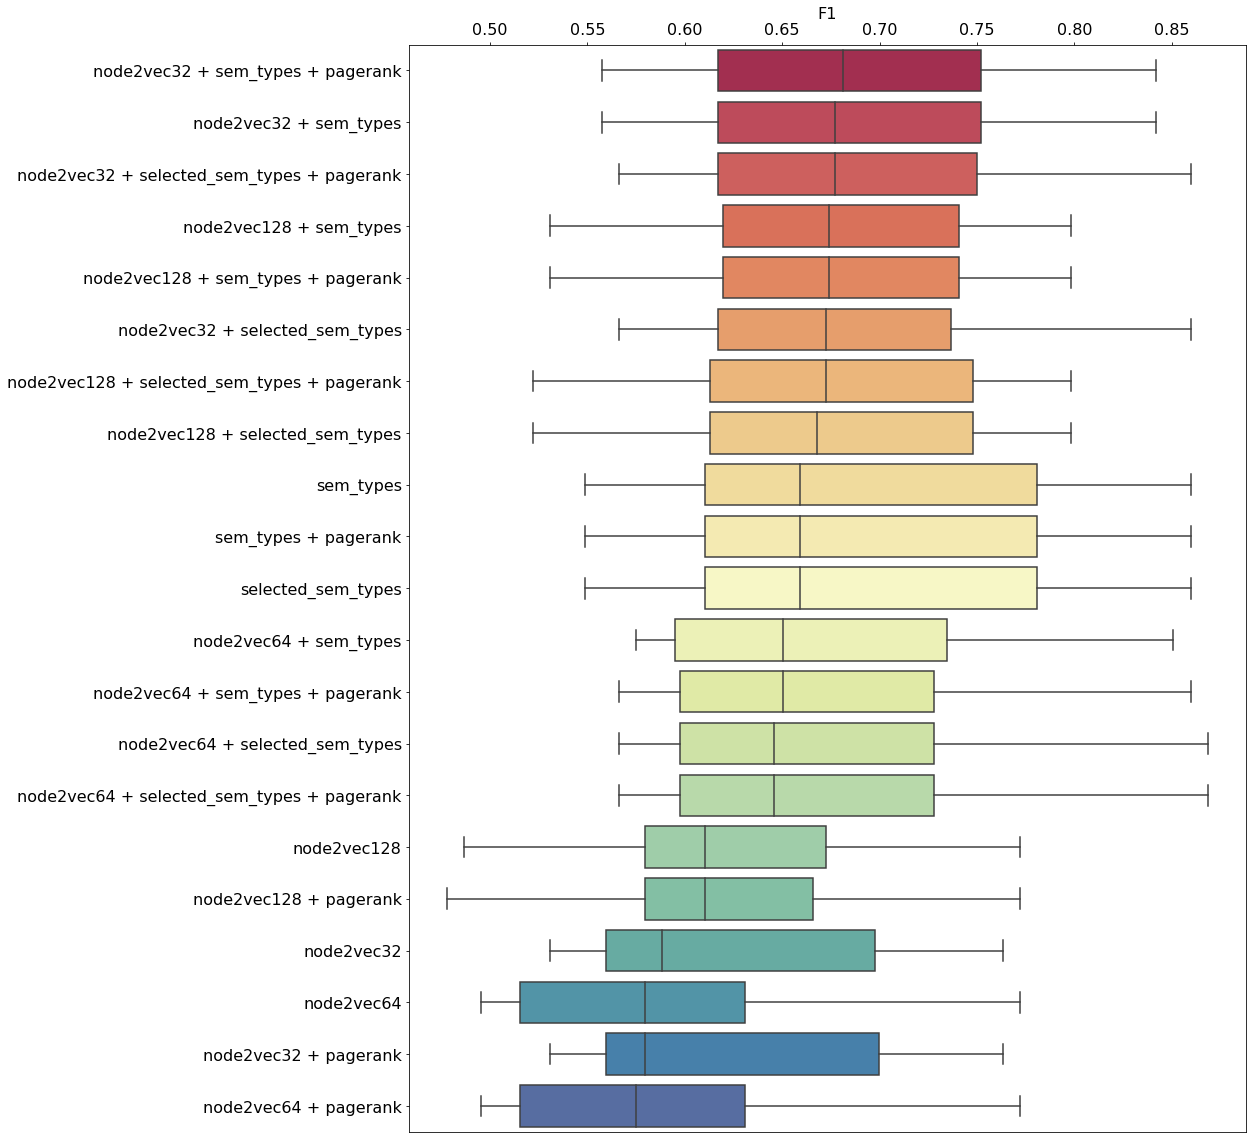

In [14]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(15)
# ax.set_title("Feature combinations scores")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("F1")
chart = sns.boxplot(data=feature_scores_df, palette="Spectral", orient='h')
# chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
plt.savefig('feature_combinations_full.pdf', bbox_inches='tight')
plt.show()

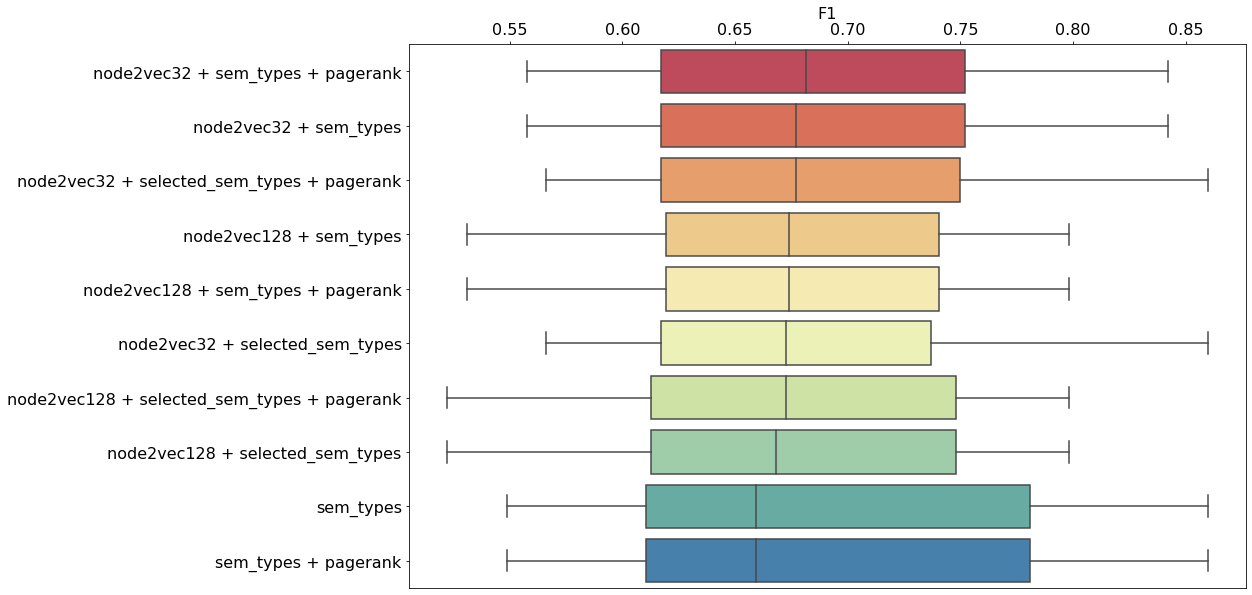

In [15]:
best_10 = feature_scores_df.iloc[:, 0:10]

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
# ax.set_title("Feature combinations scores (Best 10)")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("F1")
chart = sns.boxplot(data=best_10, palette="Spectral", orient='h')
plt.savefig('feature_combinations_best.pdf', bbox_inches='tight')
plt.show()

In [16]:
X = feature_combinations["node2vec32 + selected_sem_types + pagerank"]

In [17]:
feature_names = ['node2vec{}'.format(num) for num in range(1, 33)] + selected_sem_types + ['pagerank']
column_names = ['label'] + feature_names + ['target']

In [18]:
data = []
for ii, cui in enumerate(dataset_cuis):
    data.append([db[cui]['label']] + X[ii, :].tolist() + [Y[ii]])
train_df = pd.DataFrame(data=data, columns=column_names, index=dataset_cuis)
train_df.to_csv("./train_df.csv")

In [19]:
train_df.describe()

,node2vec1,node2vec2,node2vec3,node2vec4,node2vec5,node2vec6,node2vec7,node2vec8,node2vec9,node2vec10,...,patf,hlca,menp,anim,imft,lbpr,phsu,irda,pagerank,target
count,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,...,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000
mean,0.587083,0.494482,0.585853,0.471522,0.546715,0.519975,0.481716,0.496119,0.508826,0.536824,...,0.007055,0.010582,0.010582,0.002646,0.006173,0.009700,0.024691,0.003527,0.008896,0.488536
std,0.195025,0.218715,0.179633,0.174218,0.206349,0.196331,0.187157,0.201946,0.200873,0.178193,...,0.083732,0.102368,0.102368,0.051389,0.078359,0.098054,0.155251,0.059313,0.036076,0.500089
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.433937,0.320896,0.448624,0.355498,0.390934,0.373492,0.329893,0.346939,0.360324,0.392897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.570636,0.506997,0.571608,0.482995,0.567833,0.512374,0.456738,0.477233,0.520575,0.540668,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001850,0.000000
75%,0.745454,0.654930,0.721864,0.598088,0.702411,0.663001,0.625561,0.639452,0.661799,0.670645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006725,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Create test set

In [20]:
X_test_node2vec32 = node2vec_scaler["32"].transform(np.asarray([db[cui]["node2vec32"] for cui in test_cuis]))

selected_test_sem_types_one_hot = []
selected_test_sem_types_one_hot_dict = {}
for cui in test_cuis:
    cui_sem_types = db[cui]["sem_types"]
    row = [1 if sem_type in cui_sem_types else 0 for sem_type in selected_sem_types]
    selected_test_sem_types_one_hot.append(row)
    selected_test_sem_types_one_hot_dict[cui] = row
    
X_test_selected_sem = np.asarray(selected_test_sem_types_one_hot)

pagerank = {cui: db[cui]["pagerank"] for cui in test_cuis}
for cui in pagerank.keys():
    if not pagerank[cui]:
        pagerank[cui] = 0
X_test_pagerank = np.asarray([[pagerank[cui]] for cui in test_cuis])
X_test_pagerank = pagerank_scaler.transform(X_test_pagerank)

X_test = np.concatenate([X_test_node2vec32, X_test_selected_sem, X_test_pagerank], axis=1)

In [21]:
data = []
for ii, cui in enumerate(test_cuis):
    data.append([db[cui]['label']] + X_test[ii, :].tolist() + [test[cui]])
test_df = pd.DataFrame(data=data, columns=column_names, index=test_cuis)
test_df.to_csv("./test_df.csv")